In [1]:
import torch, matplotlib.pyplot as plt, subprocess, io

In [2]:
from model.speech_to_text import SpeechToText
from model.sign_to_text import SignToText
from model.utils import Logger as LOG
from deep_translator import GoogleTranslator

from media_processing.video import write_video_tensor_to_mp4, write_single_frame_to_png, webm_bytes_to_tensor, tensor_to_webm_bytes, load_mp4video_from_file, VideoPipeline

/Users/nielsraunkjaer/Desktop/Bachelor/SltServer/server-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# own test videos
vid = load_mp4video_from_file('processed_output.mp4')
vid_downsampled = load_mp4video_from_file('processed_output_downsampled.mp4')

In [4]:
# video subset from train data
train = [
    load_mp4video_from_file(f'./experiment-data/train{i}.mp4')
    for i in range(3)
]

# Downsampling visualizations

In [5]:
def show_frame(video_array,idx=0):
    plt.imshow(video_array[idx].detach().numpy())

In [6]:
def show_seq(video_array, idx_offset):
    w = 35
    h = 35
    fig = plt.figure(figsize=(w, h))
    columns = 10
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        show_frame(video_array, idx=i + idx_offset)
    plt.show()

In [7]:
pipe = VideoPipeline(W_in=260, H_in=210, WH_out=224, k_t=1.)

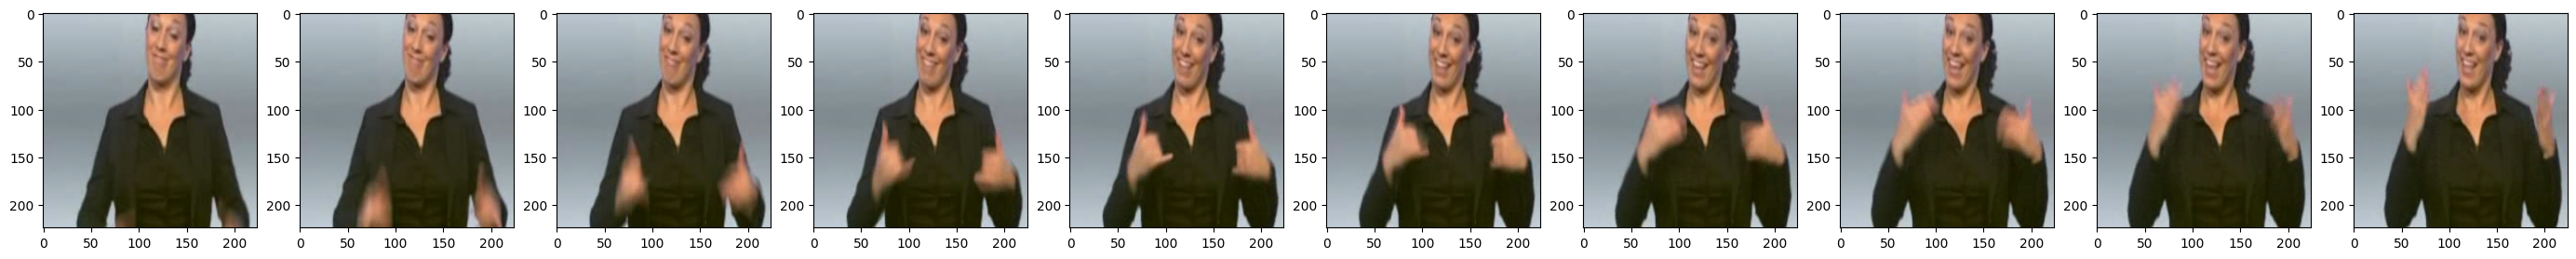

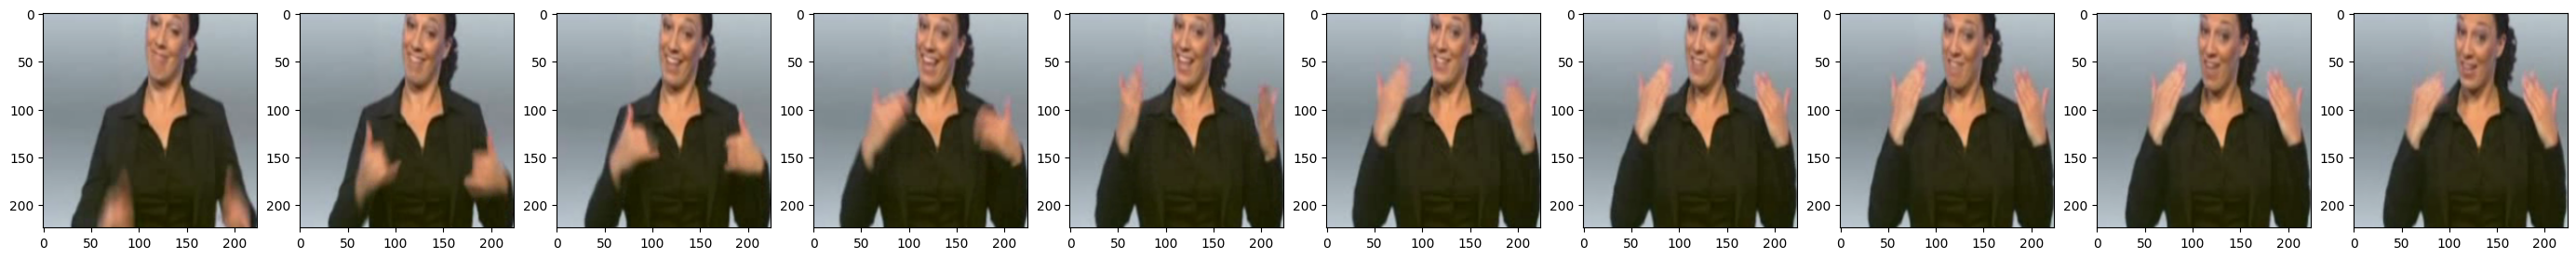

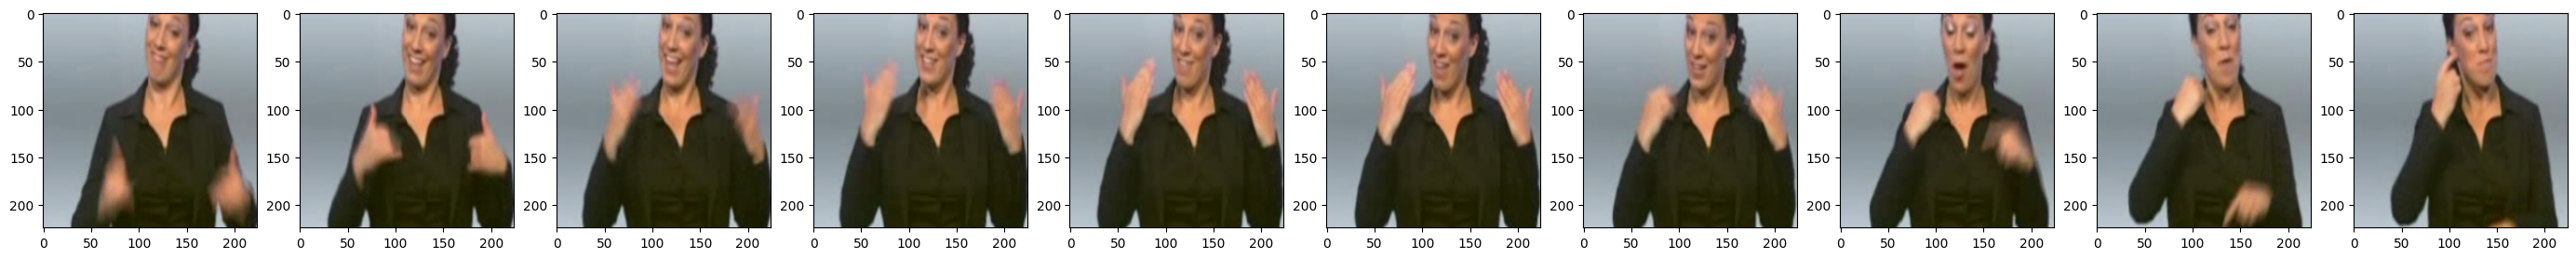

In [8]:
pipe.k_t = .5
train_1_2 = [pipe(t, to_file=True) for t in train]

pipe.k_t = .333
train_1_3 = [pipe(t, to_file=True) for t in train]

for i, t in enumerate(train):
    show_seq(t, idx_offset=0)
    show_seq(train_1_2[i], idx_offset=0)
    show_seq(train_1_3[i], idx_offset=0)
    break # only show one vid

# Performance tests

In [9]:
slt_model = SignToText()

Loading state dicts individually
Training backbone from scratch
Training head network from scratch
Freezing up to block 4 in S3D backbone
Loading model from pretrained checkpoint!


In [10]:
# ! when not performing benchmarks
# del slt_model

In [11]:
bytes = tensor_to_webm_bytes(vid)#, w=260, h=210)

In [12]:
tns = webm_bytes_to_tensor(bytes, width=224, height=224)
write_video_tensor_to_mp4(tns, w=224, h=224, OUT_FILE_PATH="test_final_v3.mp4")

/Users/nielsraunkjaer/Desktop/Bachelor/SltServer/media_processing/video.py:69: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:1468.)
  video_tensor = torch.frombuffer(stdout, dtype=torch.uint8)


In [13]:
LOG.measure_perf = True

kws_to_extract = ["variation", "_input"]

def perfmon_wrapper(func, *args, **kwargs):
    extra_kwargs = {}
    for kw in kws_to_extract:
        extra_kwarg = kwargs.get(kw, None)
        if extra_kwarg is not None:
            del kwargs[kw]
        extra_kwargs[kw] = extra_kwarg
        
    start_time, perf_time, proc_time = LOG.log_perf(func.__name__, mode=1, **extra_kwargs)
    res = func(*args, **kwargs)
    LOG.log_perf(func.__name__, mode=2, prev_start_time=start_time, prev_perf=perf_time, prev_proc=proc_time, **extra_kwargs)
    return res

In [23]:
test_function_123 = lambda: [x for x in range(10_000_000)]
_ = perfmon_wrapper(test_function_123, variation="for loop, 10^7 iters")
del _

Perf @ STARTING :: <lambda>
Perf @ FINISHED [time: 0.148845911 s] [perf_counter: 0.148845333 s] [process_time: 0.149760000 s] :: <lambda>


In [16]:
google_languages = {
            "US": "en",
            "UK": "en",
            "DE": "de",
            "DK": "da"}

In [17]:
""" Takes in a list of videos """
def test_suite(videos):
    for _video in videos:
        # ? get webm bytes, just like we receive via websocket
        data = tensor_to_webm_bytes(_video)

        # video = webm_bytes_to_tensor(data)
        video = perfmon_wrapper(webm_bytes_to_tensor, data, width = 224, height = 224)

        # video, num_frames = pipe(video, to_file=False, output_length=True)
        video, num_frames = perfmon_wrapper(pipe.__call__, video, to_file=False, output_length=True, variation="VideoPipeline, k_t=1.", _input=video.shape)

        # y = slt_model(video, num_frames)[0]
        y = perfmon_wrapper(slt_model.inference, video, num_frames, variation="Sign2Text", _input=video.shape)[0]

        lang_from, lang_to = "DE", "US"
        y = GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate(y)


In [18]:
test_suite(train[0:1])

Perf @ STARTING :: webm_bytes_to_tensor
Perf @ FINISHED [time: 0.077172041 s] [perf_counter: 0.077172208 s] [process_time: 0.027441000 s] :: webm_bytes_to_tensor
Perf @ STARTING :: __call__
Perf @ FINISHED [time: 0.067779064 s] [perf_counter: 0.067779125 s] [process_time: 0.301433000 s] :: __call__
Perf @ STARTING :: inference
Perf @ FINISHED [time: 2.467837334 s] [perf_counter: 2.467835792 s] [process_time: 5.229167000 s] :: inference


In [24]:
LOG.perf_metrics

,Unnamed: 0,Function Name,Variation,Input Dims,time,perf_counter,process_time,Input
0,0.0,<lambda>,NaN,NaN,0.142617,0.142579,0.143076,NaN
1,1.0,webm_bytes_to_tensor,NaN,NaN,0.078713,0.078696,0.029330,NaN
2,2.0,__call__,"VideoPipeline, k_t=1.",NaN,0.067429,0.067414,0.298936,"torch.Size([200, 224, 224, 3])"
3,3.0,inference,Sign2Text,NaN,2.402950,2.402468,5.191749,"torch.Size([3, 66, 224, 224])"
4,NaN,<lambda>,"for loop, 10^7 iters",None,0.148846,0.148845,0.149760,NaN


In [20]:
LOG.save_perf_metrics()
LOG.reset_perf_metrics()

In [21]:
LOG.load_perf_metrics("perf_metrics_02-06-2023_12:33:30")

In [22]:
LOG.perf_metrics

,Unnamed: 0,Function Name,Variation,Input Dims,time,perf_counter,process_time,Input
0,0,<lambda>,NaN,NaN,0.142617,0.142579,0.143076,NaN
1,1,webm_bytes_to_tensor,NaN,NaN,0.078713,0.078696,0.029330,NaN
2,2,__call__,"VideoPipeline, k_t=1.",NaN,0.067429,0.067414,0.298936,"torch.Size([200, 224, 224, 3])"
3,3,inference,Sign2Text,NaN,2.402950,2.402468,5.191749,"torch.Size([3, 66, 224, 224])"
